In [1]:
import os
from PIL import Image

import time
import numpy as np
import tensorflow as tf
import pandas as pd


from user import User
from average import Average
from tensorflow import keras

from graphing import *
from file_related import *
from inits import *
from trainers import *
SEED = 0

# import os
# os.environ['PYTHONHASHSEED']=str(SEED)
# np.random.seed(SEED)
# import random
# random.seed(SEED)
# tf.set_random_seed(SEED)
# could need to force keras to not use parallelism, see documentation

%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
VALID_IMAGE_EXTENSIONS = [".jpg", ".jpeg", ".png"] # valid extensions

def load_image(infilename):
    img = Image.open(infilename)
    img = img.resize((80,80))
    data = np.asarray(img)
    return data


    
def save_image(np_array, output_filename) :
    im = Image.fromarray(np_array, "RGB")
    im.save(output_filename)     
    
def map_images(data_dir, verbose = False):
    files = {}
    CLASSES = {}

    for class_id, class_dir in enumerate(os.listdir(data_dir)):
        class_name = class_dir
        class_dir = os.path.join(data_dir, class_dir)
        files[class_id] = []
        CLASSES[class_id] = class_name
        for file in os.listdir(class_dir):

            ext = os.path.splitext(file)[1]
            if ext in VALID_IMAGE_EXTENSIONS:

                np_im = load_image(os.path.join(class_dir,file))
                files[class_id].append(np_im)
#                 save_image(np_im,"i.jpg")
        if verbose:
            print(f"Done: {class_dir}")
    return CLASSES, files

# https://www.kaggle.com/prasunroy/natural-images
data_dir = "../testing/data/natural_images/"

CLASSES, files = map_images(data_dir)

In [3]:
def init_users_image(files,  averaging_metric="accuracy", test_size = 0.2, val_size = 0.2, shape=(80,80,3), seed=None):
    users = {}
    keys = list(files.keys())
    
    # initialise users
    for class_id in keys:
        model = init_conv_model(keys, shape, seed)
#         model = init_model()

        option = np.random.RandomState(seed).randint(0,len(averaging_methods))
        users[class_id] = User(user_id=class_id,
                  model = model,
                  averaging_method = averaging_methods[option],
                  averaging_metric = averaging_metric,
                  train_class = None,
                  train_data = None,
                  val_class = None,
                  val_data = None, 
                  test_class = None,
                  test_data = None)
    
    # for class ids in keys, we will now create a majority and rest (of the data) split
    
    for class_id in keys:
        images = np.asarray(files[class_id]).astype("float32")
        # shuffle first pls
        majority_data, rest_data = np.split(images, [int(0.7 * len(images))])
        rest_data_split = np.array_split(rest_data,len(keys)-1)  
        
        rest_data_index = 0
        for user_id in keys:
            if user_id == class_id:
                train_data, train_class, test_data, test_class, val_data, val_class = \
                    train_test_val_split(majority_data, class_id, test_size, val_size)
            else:
                raw_data = rest_data_split[rest_data_index]
                train_data, train_class, test_data, test_class, val_data, val_class = \
                    train_test_val_split(raw_data, class_id, test_size, val_size)
                rest_data_index += 1
                
            if class_id == 0:
                users[user_id].set_test_class(test_class)
                users[user_id].set_test_data(test_data)
                users[user_id].set_val_data(val_data)
                users[user_id].set_val_class(val_class)
                users[user_id].set_train_data(train_data)
                users[user_id].set_train_class(train_class)
            else:
                users[user_id].add_test_class(test_class)
                users[user_id].add_test_data(test_data)
                users[user_id].add_val_data(val_data)
                users[user_id].add_val_class(val_class)
                users[user_id].add_train_data(train_data)
                users[user_id].add_train_class(train_class)
    return users

def train_test_val_split(np_data, class_id, test_size, val_size):
    test_data, train_data = np.split(np_data, [int(test_size * len(np_data))])
    val_size = val_size/(1-test_size)
    val_data, test_data = np.split(test_data, [int(val_size * len(test_data))])
    
    train_class = np.full((train_data.shape[0]),class_id)
    test_class = np.full((test_data.shape[0]),class_id)
    val_class = np.full((val_data.shape[0]),class_id)
#     print(f"              {val_class.shape[0] == val_data.shape[0]}")
    return train_data, train_class, test_data, test_class, val_data, val_class
        
averaging_methods = [Average.all,Average.std_dev,Average.weighted_avg]
      

#     global_user = User()

In [4]:
DEVICE = '/gpu:0'
ROUNDS = 32
EPOCHS = 16

In [5]:
# forces tensorfor to the a particular device to run things
#      # return a dictionary of users with data
users_all = init_users_image(files, seed = SEED)
train_fed(users = users_all, rounds = ROUNDS,
          epochs = EPOCHS,
          strat = "central",
          train_user_verbose = False,
          train_user_verbose_evaluate = False,
          train_user_verbose_fit = False,
          averaging_method = Average.all,
          averaging_post = True,
          averaging_metric = "accuracy")

    # return a dictionary of users with data
#     users_all_2, global_user = init_users(df = df, 
#                                         averaging_methods = averaging_methods, 
#                                         seed = SEED)
#     train_fed(users = users_all_2, rounds = ROUNDS,
#               epochs = EPOCHS,
              
#               strat = "personalised",
#               train_user_verbose = False,
#               train_user_verbose_evaluate = False,
#               train_user_verbose_fit = False,
#               averaging_post = True,
#               averaging_metric = "accuracy")
    
#      print(len(users_all[2].get_history_metrics()["sparse_categorical_accuracy"]))
#     draw_graphs(users_all[2])   

********************************  0   ********************************
0 [28.319786692053324, 0.024390243]
1 [29.658505801496833, 0.00862069]
2 [36.57966995239258, 0.0078125]
3 [17.63535905391612, 0.04255319]
4 [19.69100985610694, 0.03508772]
5 [11.995550473531088, 0.2986111]
6 [18.299281780536358, 0.027972028]
7 [28.13681955048532, 0.015151516]
******************************** DONE ********************************
********************************  1   ********************************
0 [1.5327262907493404, 0.63414633]
1 [1.790964648641389, 0.4827586]
2 [1.7925033271312714, 0.2734375]
3 [1.5732137505889785, 0.53900707]
4 [1.9267007844489918, 0.24561404]
5 [1.2671027580897014, 0.7638889]
6 [1.3401200637950763, 0.72727275]
7 [1.932496959512884, 0.37121212]
******************************** DONE ********************************
********************************  2   ********************************
0 [0.6218433351051517, 0.8292683]
1 [0.9813798624893715, 0.73275864]
2 [1.3446067869663239, 0

All
For central
Final values for Pre-fit accuracy
Position                   Pre
Round                       31
Average               0.805521
Standard Deviation    0.143425
Minimum               0.526316
Maximum               0.979167
Name: 62, dtype: object
Final values for Post-fit accuracy
Position                  Post
Round                       31
Average               0.838861
Standard Deviation    0.102486
Minimum               0.640351
Maximum               0.979167
Name: 63, dtype: object



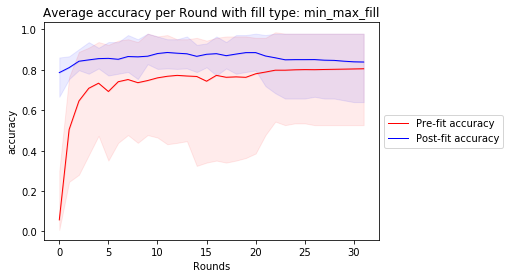

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.902439
3     1     0.862069
5     2     0.726562
7     3     0.879433
9     4     0.526316
11    5     0.979167
13    6     0.909091
15    7     0.659091
Averaged: 0.8055209293961525

Final accuracy for Post-fit data
   User  Final Value
0     0     0.902439
2     1     0.870690
4     2     0.750000
6     3     0.879433
8     4     0.640351
10    5     0.979167
12    6     0.916084
14    7     0.772727
Averaged: 0.8388612493872643



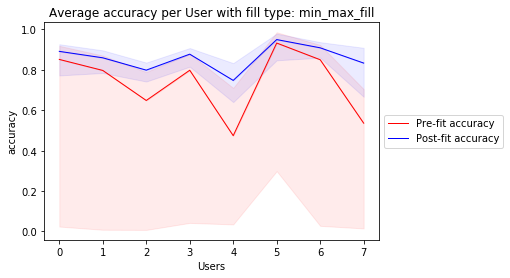

<Figure size 432x288 with 0 Axes>

In [6]:
ignore_first_n = 0
final_values = True

GRAPHING_METRIC = "accuracy"


print("All")

# print("For p2p")


# df_avg_round_stats_acc = avg_round_stats(users_all_2, 
#                                          ignore_first_n = ignore_first_n, 
#                                          min_max_fill = True, 
#                                          metric = "accuracy",
#                                          final_values = final_values)
# df_avg_user_stats_acc = avg_user_stats(users_all_2, 
#                                        ignore_first_n = ignore_first_n, 
#                                        min_max_fill = True, 
#                                        metric = "accuracy",
#                                        final_values = final_values)
print("For central")


df_avg_round_stats_acc = avg_round_stats(users_all, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC,
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_all, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC,
                                       final_values = final_values)

In [7]:
averaging_methods = [Average.std_dev]
# return a dictionary of users with data
users_std_dev = init_users_image(files, seed = SEED)
train_fed(users = users_std_dev, rounds = ROUNDS,
          epochs = EPOCHS,
          strat = "central",
          train_user_verbose = False,
          train_user_verbose_evaluate = False,
          train_user_verbose_fit = False,
          averaging_method =  Average.std_dev,
         averaging_post = True,
          averaging_metric = "accuracy")

# return a dictionary of users with data
users_std_dev_2 = init_users_image(files, seed = SEED)
train_fed(users = users_std_dev_2, rounds = ROUNDS,
          epochs = EPOCHS,
          strat = "personalised",
          train_user_verbose = False,
          train_user_verbose_evaluate = False,
          train_user_verbose_fit = False,
          averaging_post = True,
          averaging_metric = "accuracy")



********************************  0   ********************************
0 [28.319786692053324, 0.024390243]
1 [29.658505801496833, 0.00862069]
2 [36.57966995239258, 0.0078125]
3 [17.63535905391612, 0.04255319]
4 [19.69100985610694, 0.03508772]
5 [11.995550473531088, 0.2986111]
6 [18.299281780536358, 0.027972028]
7 [28.13681955048532, 0.015151516]
User 4: 0.6228070259094238 < 0.6834548830559845
User 7: 0.6666666865348816 < 0.6834548830559845
******************************** DONE ********************************
********************************  1   ********************************
0 [1.1456147800616132, 0.6910569]
1 [1.7449834141237983, 0.45689654]
2 [1.7775892317295074, 0.3046875]
3 [1.529300313469366, 0.5177305]
4 [1.9344710383498878, 0.24561404]
5 [0.7225821415583292, 0.8125]
6 [1.2392438858539074, 0.67132866]
7 [1.9248864289486047, 0.3409091]
User 7: 0.689393937587738 < 0.7523393566205739
******************************** DONE ********************************
*************************

Std deviation
For central
Final values for Pre-fit accuracy
Position                   Pre
Round                       31
Average               0.801561
Standard Deviation    0.163235
Minimum               0.429825
Maximum               0.958333
Name: 62, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        31
Average                0.872164
Standard Deviation    0.0746735
Minimum                 0.72807
Maximum                0.958333
Name: 63, dtype: object



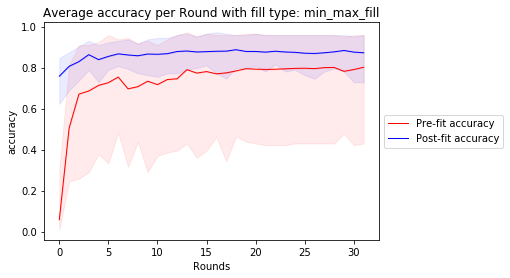

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.886179
3     1     0.853448
5     2     0.742188
7     3     0.914894
9     4     0.429825
11    5     0.958333
13    6     0.923077
15    7     0.704545
Averaged: 0.8015610612928867

Final accuracy for Post-fit data
   User  Final Value
0     0     0.894309
2     1     0.870690
4     2     0.820312
6     3     0.950355
8     4     0.728070
10    5     0.958333
12    6     0.937063
14    7     0.818182
Averaged: 0.8721642419695854



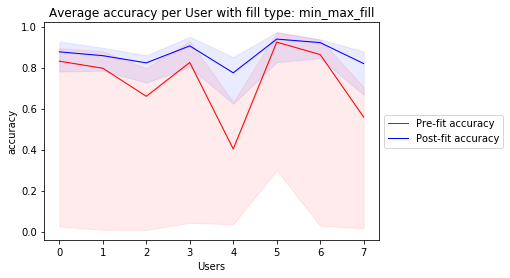

For p2p
Final values for Pre-fit accuracy
Position                   Pre
Round                       31
Average               0.811217
Standard Deviation    0.121945
Minimum               0.578947
Maximum               0.951389
Name: 62, dtype: object
Final values for Post-fit accuracy
Position                  Post
Round                       31
Average               0.869706
Standard Deviation    0.060722
Minimum                0.77193
Maximum               0.951389
Name: 63, dtype: object



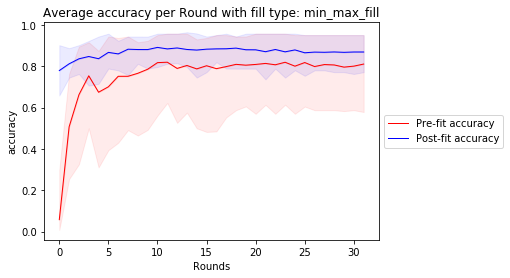

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.918699
3     1     0.836207
5     2     0.710938
7     3     0.872340
9     4     0.578947
11    5     0.951389
13    6     0.909091
15    7     0.712121
Averaged: 0.8112165555357933

Final accuracy for Post-fit data
   User  Final Value
0     0     0.918699
2     1     0.844828
4     2     0.781250
6     3     0.886525
8     4     0.771930
10    5     0.951389
12    6     0.909091
14    7     0.893939
Averaged: 0.8697063252329826



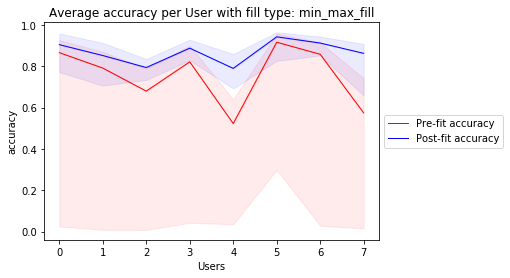

<Figure size 432x288 with 0 Axes>

In [8]:
ignore_first_n = 0
final_values = True
GRAPHING_METRIC = "accuracy"

print("Std deviation")
print("For central")


df_avg_round_stats_acc = avg_round_stats(users_std_dev, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC,
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_std_dev, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC,
                                       final_values = final_values)
print("For p2p")


df_avg_round_stats_acc = avg_round_stats(users_std_dev_2, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC,
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_std_dev_2, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC,
                                       final_values = final_values)


# print(users_std_dev[1].get_history_metrics())


In [9]:
averaging_methods = [Average.weighted_avg]

# return a dictionary of users with data
users_weighted_avg = init_users_image(files, seed = SEED)
train_fed(users = users_weighted_avg, rounds = ROUNDS,
          epochs = EPOCHS,
          strat = "central",
          train_user_verbose = False,
          train_user_verbose_evaluate = False,
          train_user_verbose_fit = False,
          averaging_method = Average.weighted_avg,
          averaging_post = True,
          averaging_metric = "accuracy")

# return a dictionary of users with data
users_weighted_avg_2 = init_users_image(files, seed = SEED)
train_fed(users = users_weighted_avg_2, rounds = ROUNDS,
          epochs = EPOCHS,
          strat = "personalised",
          train_user_verbose = False,
          train_user_verbose_evaluate = False,
          train_user_verbose_fit = False,
          averaging_post = True,
          averaging_metric = "accuracy")

********************************  0   ********************************
0 [28.319786692053324, 0.024390243]
1 [29.658505801496833, 0.00862069]
2 [36.57966995239258, 0.0078125]
3 [17.63535905391612, 0.04255319]
4 [19.69100985610694, 0.03508772]
5 [11.995550473531088, 0.2986111]
6 [18.299281780536358, 0.027972028]
7 [28.13681955048532, 0.015151516]
******************************** DONE ********************************
********************************  1   ********************************
0 [1.5325518158393177, 0.6097561]
1 [1.7972740387094432, 0.5]
2 [1.844835251569748, 0.28125]
3 [1.5800772846167814, 0.5460993]
4 [1.8892905293849476, 0.2982456]
5 [1.2638828224605985, 0.7361111]
6 [1.3737934636069344, 0.7202797]
7 [1.8999837962063877, 0.36363637]
******************************** DONE ********************************
********************************  2   ********************************
0 [0.6536397284608546, 0.8211382]
1 [1.0942262534437508, 0.7413793]
2 [1.5739030241966248, 0.609375]
3 [

Weighted average
For central
Final values for Pre-fit accuracy
Position                   Pre
Round                       31
Average               0.805314
Standard Deviation     0.12983
Minimum               0.596491
Maximum               0.958333
Name: 62, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        31
Average                0.836044
Standard Deviation    0.0922166
Minimum                0.675439
Maximum                0.958333
Name: 63, dtype: object



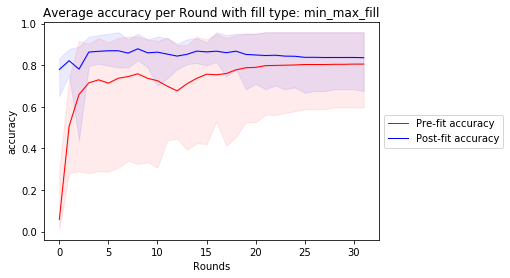

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.894309
3     1     0.879310
5     2     0.710938
7     3     0.865248
9     4     0.596491
11    5     0.958333
13    6     0.909091
15    7     0.628788
Averaged: 0.8053135424852371

Final accuracy for Post-fit data
   User  Final Value
0     0     0.894309
2     1     0.879310
4     2     0.734375
6     3     0.872340
8     4     0.675439
10    5     0.958333
12    6     0.909091
14    7     0.765152
Averaged: 0.8360436335206032



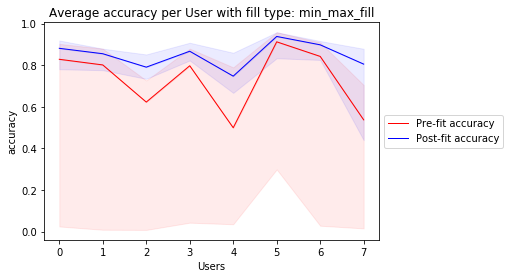

For p2p
Final values for Pre-fit accuracy
Position                   Pre
Round                       31
Average               0.815211
Standard Deviation    0.127042
Minimum               0.596491
Maximum               0.965278
Name: 62, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        31
Average                0.856338
Standard Deviation    0.0810186
Minimum                0.710526
Maximum                0.965278
Name: 63, dtype: object



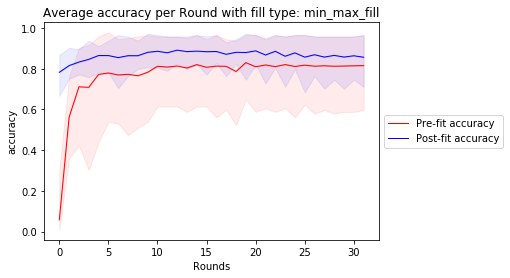

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.894309
3     1     0.862069
5     2     0.750000
7     3     0.886525
9     4     0.596491
11    5     0.965278
13    6     0.923077
15    7     0.643939
Averaged: 0.8152109980583191

Final accuracy for Post-fit data
   User  Final Value
0     0     0.902439
2     1     0.879310
4     2     0.789062
6     3     0.900709
8     4     0.710526
10    5     0.965278
12    6     0.923077
14    7     0.780303
Averaged: 0.8563381358981133



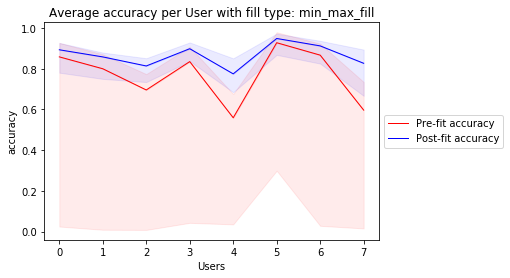

<Figure size 432x288 with 0 Axes>

In [10]:
ignore_first_n = 0
final_values = True
GRAPHING_METRIC = "accuracy"

print("Weighted average")

print("For central")


df_avg_round_stats_acc = avg_round_stats(users_weighted_avg, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC,
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_weighted_avg, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC,
                                       final_values = final_values)

print("For p2p")


df_avg_round_stats_acc = avg_round_stats(users_weighted_avg_2, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC,
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_weighted_avg_2, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC,
                                       final_values = final_values)


In [11]:
users_local_only = init_users_image(files, seed = SEED)
train_fed(users = users_local_only, rounds = ROUNDS,
          epochs = EPOCHS,

          strat = "local_trainings_only",
          train_user_verbose = False,
          train_user_verbose_evaluate = False,
          train_user_verbose_fit = False,
          averaging_post = True,
          averaging_metric = "accuracy")
        
#     print("Global user training and validation")

#     global_user.train(epochs = EPOCHS*ROUNDS,
#        verbose_fit = False,
#        verbose_evaluate = False,
#     )

********************************  0   ********************************
0 [28.319786692053324, 0.024390243]
1 [29.658505801496833, 0.00862069]
2 [36.57966995239258, 0.0078125]
3 [17.63535905391612, 0.04255319]
4 [19.69100985610694, 0.03508772]
5 [11.995550473531088, 0.2986111]
6 [18.299281780536358, 0.027972028]
7 [28.13681955048532, 0.015151516]
******************************** DONE ********************************
********************************  1   ********************************
0 [1.0423602805874213, 0.7804878]
1 [0.9797728143889328, 0.8448276]
2 [1.9267134256660938, 0.7421875]
3 [0.7390234360458158, 0.80851066]
4 [3.0216068301284524, 0.7719298]
5 [0.8133682161569593, 0.875]
6 [0.9834613053948729, 0.8321678]
7 [1.5848557118213538, 0.6666667]
******************************** DONE ********************************
********************************  2   ********************************
0 [1.7217696006826269, 0.7804878]
1 [1.4862945655296589, 0.8189655]
2 [3.618553530155623, 0.796875]

Local training only
Final values for Pre-fit accuracy
Position                    Pre
Round                        31
Average                0.818284
Standard Deviation    0.0333916
Minimum                 0.77193
Maximum                0.881944
Name: 62, dtype: object
Final values for Post-fit accuracy
Position                  Post
Round                       31
Average               0.819381
Standard Deviation    0.031965
Minimum               0.780702
Maximum               0.881944
Name: 63, dtype: object



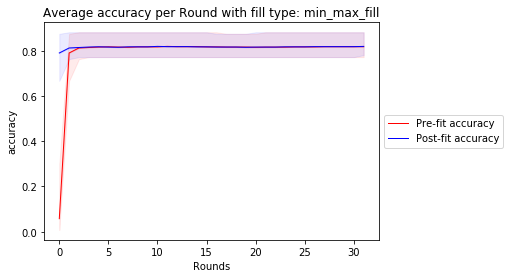

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.804878
3     1     0.818965
5     2     0.796875
7     3     0.808511
9     4     0.771930
11    5     0.881944
13    6     0.860140
15    7     0.803030
Averaged: 0.818284198641777

Final accuracy for Post-fit data
   User  Final Value
0     0     0.804878
2     1     0.818965
4     2     0.796875
6     3     0.808511
8     4     0.780702
10    5     0.881944
12    6     0.860140
14    7     0.803030
Averaged: 0.8193806931376457



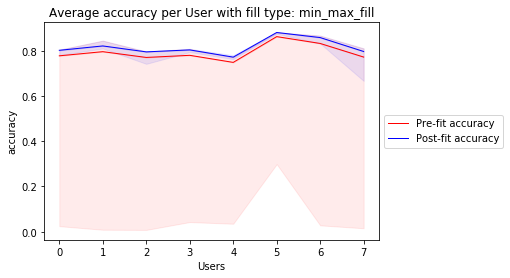

<Figure size 432x288 with 0 Axes>

In [12]:
ignore_first_n = 0
final_values = True
GRAPHING_METRIC = "accuracy"


print("Local training only")


df_avg_round_stats_acc = avg_round_stats(users_local_only, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC,
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_local_only, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC,
                                       final_values = final_values)
# draw_graphs(users_all_2[2])

# print("Global user")
# draw_graphs(global_user)
# global_user.evaluate(verbose=False)

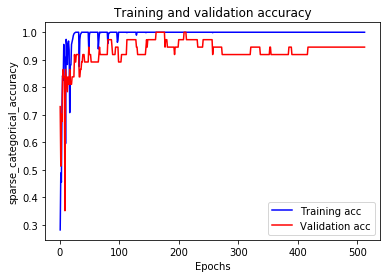

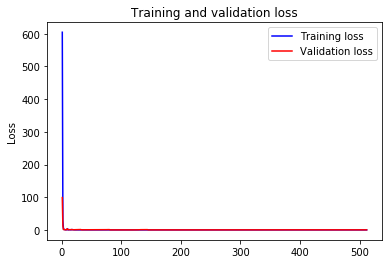

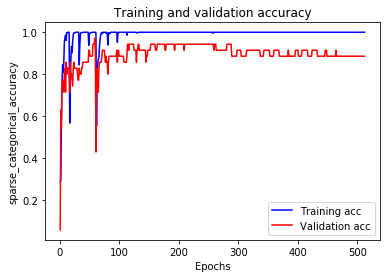

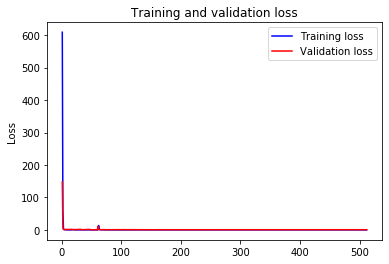

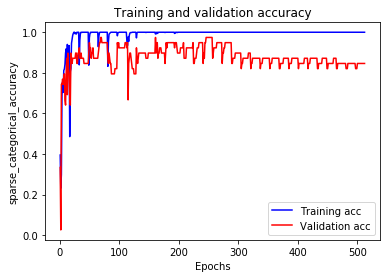

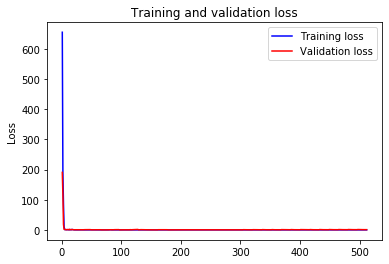

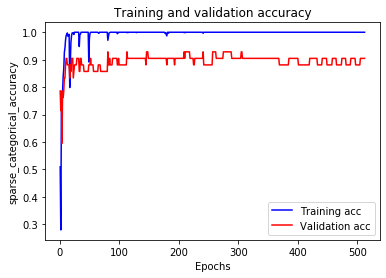

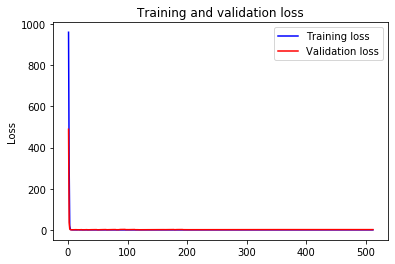

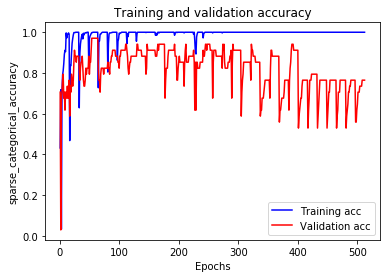

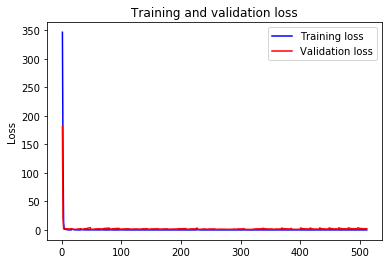

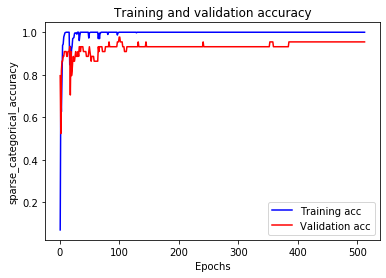

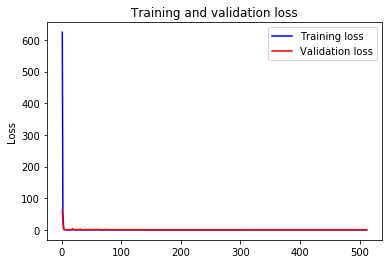

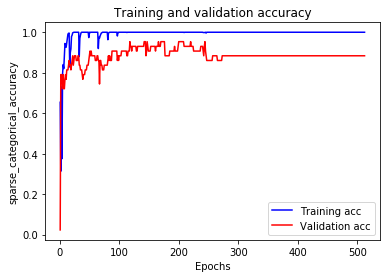

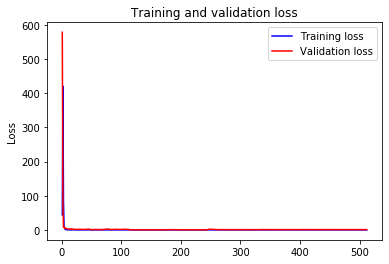

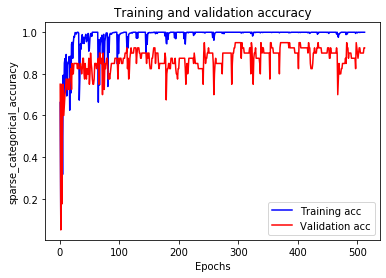

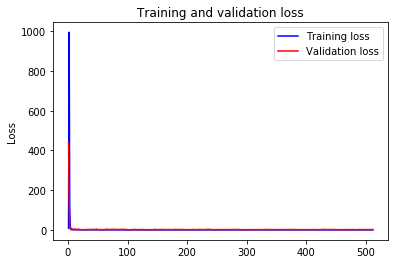

<Figure size 432x288 with 0 Axes>

In [13]:
for user in users_std_dev_2.values():
    draw_graphs(user)